References:
- [How to Visualize Gradient Boosting Decision Trees With XGBoost in Python](https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/)

# Instagram Like Prediction @310ai Competition - Modeling, Visualization & Evaluation

This notebook is a continuation of ***Data*** notebook. In this part of project we will train the predictive model, analyze it, visualize its output and evaluate it. The reason for this separation, is to make the notebooks easier to understand and less dependent on each other, especially for this case since the Instagram showed that it reguralry changing its api and bot mitigation methods. Multiple stages of this project have checkpoints, thus the notebook will run without issues.

As we pointed out in the previous notebook, we will use **XGBoost 1.7** as the algorithm. So let's without further ado, dive into it.

In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

First thing first, we must load the data, also we have some identifying features, called shortcode, username and id, which will not affect the accuracy of the model, thus we can drop these features all together.

In [5]:
df = pd.read_csv('Data/main v3.0.csv')
df.drop(columns=['Unnamed: 0', 'shortcode', 'username', 'id'], inplace=True)
df.head()

,post_type,like,comment,category_name,follower,following,ar_effect,type_business,type_professional,verified,...,reel_avg_view,reel_avg_comment,reel_avg_like,reel_avg_duration,reel_frequency,media_count,media_avg_comment,media_avg_like,media_frequency,object
0,GraphSidecar,390465,7037,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,"pot, flowerpot"
1,GraphSidecar,320587,6746,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,"rock_crab, Cancer_irroratus"
2,GraphSidecar,480033,9096,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,"feather_boa, boa"
3,GraphSidecar,351673,6692,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,"teddy, teddy_bear"
4,GraphImage,273314,6878,Digital creator,633916664,59,True,False,True,True,...,"9,409,868.50","13,527.08","572,818.75",92.47,18.55,7408,"8,552.00","473,666.50",1.19,wig


Now we can separate independent and dependent variables. Usually we cal independent variables X and dependent variables y.

In [6]:
# remove objects from instagram detection algorithm and only use efficient net algorithm
exclude_columns = [
    'like',
]
X, y = df.loc[:, ~df.columns.isin(exclude_columns)].copy(), df[['like']].copy()

As we said in the previous notebook, XGBoost since the version of 1.7 is capable of working with categorical variables, but before casting the categorical variables through the model, we must change the type of those features to `categorical` in pandas.

In [7]:
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
for feature in categorical_features:
    X[feature] = X[feature].astype('category')

Now we can split the data into training and validation. We will use the 25% of data as validation set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

### What architecture and pre trained models -if any- you used?

In this cell we will define hyperparameters value for model. Have in mind that since we will perform a cross-validation, parameters are actually list of parameters to find the best one among their combination.

In [9]:
# creating a baseline model
mean_train = np.mean(np.asarray(y_train))
baseline_predictions = np.ones(np.asarray(y_test).shape) * mean_train
mae_baseline = mean_absolute_error(np.asarray(y_test), baseline_predictions)
print(f'Baseline MAE: {mae_baseline:.2f}')

Baseline MAE: 1852641.94


In [20]:
params = {
    'max_depth': 6,             # maximum depth of a tree
    'min_child_weight': 1,      # minimum sum of weights of all observations required in a child
    'eta': .25,                 # learning rate
    'subsample': 1,             # fraction of observation to be random samples for each tree
}
num_boost_rounds = 700

Tunning `max_depth`, `min_child_weight`, `eta` and `subsample` hyperparameters.

In [23]:
grid_search_params = [
    (max_depth, min_child_weight, eta, subsample)
    for max_depth in range(13, 15)
    for min_child_weight in range(5, 10)
    for eta in [.05, .01, .005]
    for subsample in [i/10. for i in range(8, 11)]
]

min_mae = float('Inf')
best_params = None
for max_depth, min_child_weight, eta, subsample in grid_search_params:
    print(f'CV with max_depth: {max_depth}, min_child_weight: {min_child_weight}, eta: {eta}, subsample: {subsample}')

    # updating parameters dictionary
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['eta'] = eta
    params['subsample'] = subsample

    # performing cv
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_rounds,
        seed=69,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10,
    )

    # updating the best mae
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print(f'\tMAE: {mean_mae:,.2f}, rounds: {boost_rounds}')
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth, min_child_weight, eta, subsample)

# best hyperparameters combination
print('Best hyperparameters:')
print(f'\tmax_depth: {max_depth}')
print(f'\tmin_child_weight: {min_child_weight}')
print(f'\teta: {eta}')
print(f'\tsubsample: {subsample}')
print(f'\tmae: {min_mae}')

CV with max_depth: 13, min_child_weight: 5, eta: 0.05, subsample: 0.8
	MAE: 309,778.25, rounds: 98
CV with max_depth: 13, min_child_weight: 5, eta: 0.05, subsample: 0.9
	MAE: 313,459.54, rounds: 89
CV with max_depth: 13, min_child_weight: 5, eta: 0.05, subsample: 1.0
	MAE: 324,438.10, rounds: 89
CV with max_depth: 13, min_child_weight: 5, eta: 0.01, subsample: 0.8
	MAE: 305,930.19, rounds: 413
CV with max_depth: 13, min_child_weight: 5, eta: 0.01, subsample: 0.9
	MAE: 310,944.76, rounds: 416
CV with max_depth: 13, min_child_weight: 5, eta: 0.01, subsample: 1.0
	MAE: 319,821.72, rounds: 520
CV with max_depth: 13, min_child_weight: 5, eta: 0.005, subsample: 0.8
	MAE: 311,672.79, rounds: 699
CV with max_depth: 13, min_child_weight: 5, eta: 0.005, subsample: 0.9
	MAE: 315,626.20, rounds: 699
CV with max_depth: 13, min_child_weight: 5, eta: 0.005, subsample: 1.0
	MAE: 325,810.56, rounds: 699
CV with max_depth: 13, min_child_weight: 6, eta: 0.05, subsample: 0.8
	MAE: 305,872.01, rounds: 109


As we can see from the result of cross validation, the best hyperparameters for the model is:
- **max_depth**: 13
- **min_child_weight**: 9
- **eta**: 0.005
- **subsample**: 1

now lets train a model based on these hyperparameters and test it with test dataset.

TODO:
- It seems like we can increase the maxdepth to get more accuracy, test this hypothesis with stable min_child_weight, eta and subsample since they don't seem to change and their stable value has been found out.

In [15]:
params = {
    'max_depth': 13,            # maximum depth of a tree
    'min_child_weight': 9,      # minimum sum of weights of all observations required in a child
    'eta': .005,                # learning rate
    'subsample': 1,             # fraction of observation to be random samples for each tree
    'eval_metric': 'mae',
}
num_boost_rounds = 1500

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_rounds,
    evals=[(dtest, 'test')],
    early_stopping_rounds=10,
)

[0]	test-mae:1540579.99055
[1]	test-mae:1533835.46675
[2]	test-mae:1527080.44184
[3]	test-mae:1520339.40133
[4]	test-mae:1513696.26405
[5]	test-mae:1507009.78166
[6]	test-mae:1500395.79291
[7]	test-mae:1493796.65078
[8]	test-mae:1487239.14372
[9]	test-mae:1480711.38660
[10]	test-mae:1474182.27106
[11]	test-mae:1467729.84404
[12]	test-mae:1461265.88473
[13]	test-mae:1454830.97508
[14]	test-mae:1448466.71189
[15]	test-mae:1442126.03475
[16]	test-mae:1435785.81829
[17]	test-mae:1429476.39137
[18]	test-mae:1423203.29963
[19]	test-mae:1417035.15248
[20]	test-mae:1410819.75134
[21]	test-mae:1404626.40220
[22]	test-mae:1398523.85261
[23]	test-mae:1392432.87360
[24]	test-mae:1386356.62678
[25]	test-mae:1380345.94383
[26]	test-mae:1374345.38322
[27]	test-mae:1368394.42771
[28]	test-mae:1362472.18470
[29]	test-mae:1356559.50326
[30]	test-mae:1350687.31647
[31]	test-mae:1344827.56855
[32]	test-mae:1339009.39570
[33]	test-mae:1333231.06043
[34]	test-mae:1327479.18507
[35]	test-mae:1321726.68169
[3

In [16]:
print(f'Best MAE: {model.best_score:,.2f} in {model.best_iteration + 1} round.')

Best MAE: 397,449.37 in 1005 round.


Now we can train the best model for the purpose, now we have use all of the data to train a final model and deply it.

In [17]:
num_boost_rounds = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round= num_boost_rounds,
    evals=[(dtest, 'Test')]
)

[0]	Test-mae:1540579.99055
[1]	Test-mae:1533835.46675
[2]	Test-mae:1527080.44184
[3]	Test-mae:1520339.40133
[4]	Test-mae:1513696.26405
[5]	Test-mae:1507009.78166
[6]	Test-mae:1500395.79291
[7]	Test-mae:1493796.65078
[8]	Test-mae:1487239.14372
[9]	Test-mae:1480711.38660
[10]	Test-mae:1474182.27106
[11]	Test-mae:1467729.84404
[12]	Test-mae:1461265.88473
[13]	Test-mae:1454830.97508
[14]	Test-mae:1448466.71189
[15]	Test-mae:1442126.03475
[16]	Test-mae:1435785.81829
[17]	Test-mae:1429476.39137
[18]	Test-mae:1423203.29963
[19]	Test-mae:1417035.15248
[20]	Test-mae:1410819.75134
[21]	Test-mae:1404626.40220
[22]	Test-mae:1398523.85261
[23]	Test-mae:1392432.87360
[24]	Test-mae:1386356.62678
[25]	Test-mae:1380345.94383
[26]	Test-mae:1374345.38322
[27]	Test-mae:1368394.42771
[28]	Test-mae:1362472.18470
[29]	Test-mae:1356559.50326
[30]	Test-mae:1350687.31647
[31]	Test-mae:1344827.56855
[32]	Test-mae:1339009.39570
[33]	Test-mae:1333231.06043
[34]	Test-mae:1327479.18507
[35]	Test-mae:1321726.68169
[3

In [18]:
mean_absolute_error(best_model.predict(dtest), y_test)

397449.36585201905

In [11]:
best_model.save_model('Models/xgb.pth')

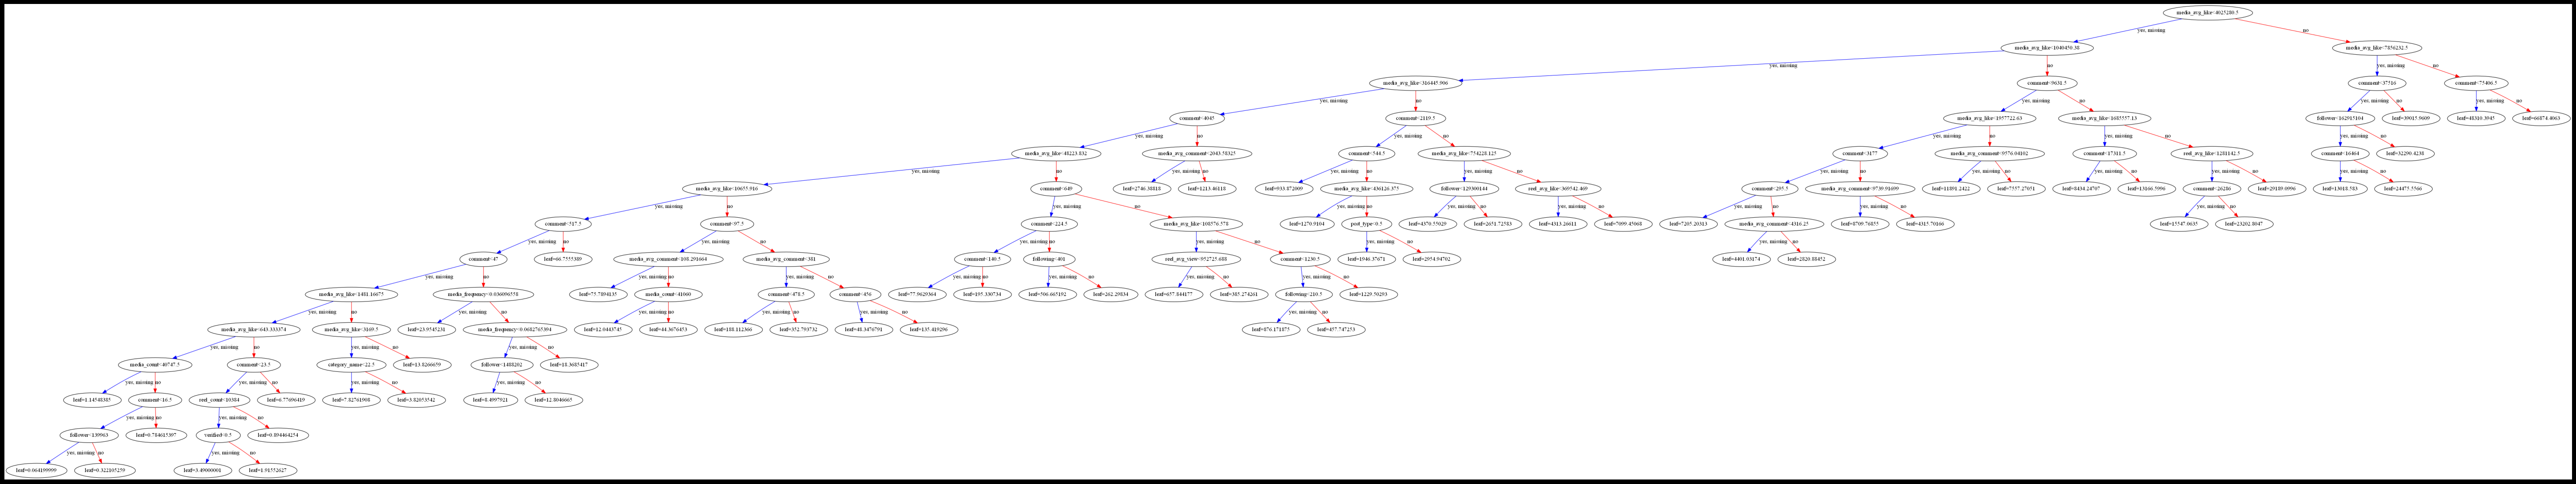

In [12]:
xgb.plot_tree(best_model)
fig = plt.gcf()
fig.set_size_inches(75, 50)
fig.savefig('tree.png')

In [17]:
model.

20